In [1]:
# Install dependencies
# !pip install -r requirements.txt

Exporting FastAI ResNet model to ONNX is a 2 step process - there's no native FastAI to ONNX export. Since, FastAI is a high-level API built on top of PyTorch - first we need to extract the PyTorch model. Only after that it's possible to get our ONNX model. Couple of things must be considered which I'll talk about and show later.

Steps to be taken:

1. Extract PyTorch model from FastAI
2. Convert PyTorch model to ONNX

## 0. (Optional) Train your own resnet model

### Dataset



1. Dataset used in this notebook: https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog/data.

2. Training your own models - If you'd like to train a model with your own data please keep the folder structure - each folder and image in the folder should have the label in their name. The label is extracted with regex `r'(.+)_\d+.jpg$'`. If you have a dataset with a different naming convention please define a suitable regex. For other options see https://docs.fast.ai/tutorial.vision.html

Folder structure:

        dataset
        ├───hot_dog
        │   ├───hot_dot_1.png
        │   ├───hot_dot_2.png
        │   └───hot_dot_xyz.png
        └───not_hot_dog
            ├───not_hot_dot_1.png
            ├───not_hot_dot_2.png
            └───not_hot_dot_xyz.png


Alternatively, you can download the trained model here: https://storage.googleapis.com/fastai-onnx-20210706/hot_dog_model_resnet18_256_256.pkl. And continue with model load, extraction, and export to ONNX.

In [2]:
# imports
from fastai.vision.all import *

In [3]:
# set dataset root directory
PATH = Path('dataset/')

In [4]:
# By itself, a DataBlock is just a blue print on how to assemble your data
# https://docs.fast.ai/data.block.html

# Good write up here:
# https://www.kaggle.com/getting-started/168549

dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(),                                  # splits dataset to train and test
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),  # extracts label from image name
    item_tfms=Resize(256),                                      # applied to all items in a dataset
    batch_tfms=aug_transforms(size=256)                         # transformation applied to a batch
    )

In [7]:
dls = dogs.dataloaders(PATH, num_workers=0, verbose=True) # CPU implmentation

Found 200 items
2 datasets of sizes 160,40
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize -- {'size': (256, 256), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': 256, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}


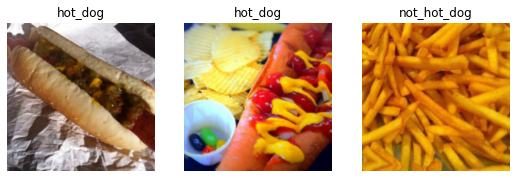

In [8]:
# show a random batch of images with their labels
dls.show_batch(max_n=3)

In [10]:
# Creates CNN learner
# you can find other supported models here:
# please stick to resnet models - resnet18, resnet34, resnet50, resnet101, resnet152
# in general more layers -> longer training and better performance

learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

In [ ]:
# finds the best learning rate
# Check this article for the maths behind: 
# https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

learn.lr_find()

In [ ]:
# you might want to change the number of training epochs - 1. argument
# you should adjust the learning rate based on the previous step - 2. argument

learn.fine_tune(8, 1e-3)

In [ ]:
# plot training loss 
learn.recorder.plot_loss()

In [ ]:
# export FastAI learner

learn.export('models/hot_dog_model_resnet18_256_256.pkl')

## Note: If want to skip the model training part - THIS is the point where you can continue
I uploaded a trained model to storage. You can download it and continue with below steps.

1. Please download the following FastAI learner: https://storage.googleapis.com/fastai-onnx-20210706/hot_dog_model_resnet18_256_256.pkl
2. Copy the donwloaded file to `models` directory.

In [11]:
# load FastAI learner
learn = load_learner('models/hot_dog_model_resnet18_256_256.pkl')

## Test inference with FastAI learner

In [12]:
# not hot dog
print(learn.predict('test_images/not_hot_dog_160.jpg'))

# hot dog
print(learn.predict('test_images/hot_dog_114.jpg'))

('not_hot_dog', tensor(1), tensor([0.0018, 0.9982]))


('hot_dog', tensor(0), tensor([9.9910e-01, 8.9894e-04]))


## 1. Getting the PyTorch model

By using .model attribute on the FastAI learner we get the 'pure' PyTorch model. By using eval() we are setting the model to 'prediction' mode - backward propagation is disabled.

#### Note:
FastAI learner wraps the PyTorch model with additional operations defined in `DataBlock` in this case we defined a `Resize` operation. By default, FastAI learner also includes a softmax layer and a normalization layer.

### What does this mean ?
If we run `learn.predict('path/to/image')` our FastAI learner resizes the image to the size defined in our `DataBlock`, normalizes the color channels, passes the image through the neural net, scales the inference results between 0-1.

If we'd try to run inference on a PyTorch model extracted from a FastAI wrapper it would fail (most likely) as the image has an incorrect resolution. That's why we need to add transformations to a PyTorch models before inference.

In [13]:
# transformations performed on data loaders
learn.dls.transform

(#2) [[noop:
encodes: (object,object) -> noopdecodes: , PILBase.create:
encodes: (Path,object) -> create
(str,object) -> create
(Tensor,object) -> create
(ndarray,object) -> create
(bytes,object) -> createdecodes: ],partial:
encodes: (object,object) -> partialdecodes: ]

In [14]:
# extract labels from learner
labels = learn.dls.vocab
labels

['hot_dog', 'not_hot_dog']

### Let's add the missing parts to our Pytorch model

As mentioned previously, FastAI learner wraps out PyTorch model. We are adding 2 additional layers to the models to achieve the same results as the FastAI learner. 

### Why can't we just export the learner to ONNX?
AFAIK FastAI currently doesn't support ONNX exports. We need to extract the PyTorch model as an intermediary step before we can convert it to ONNX. 

--------

### Additional layers:

#### Normalization layer
First we need to add a normalization layer. Pre-trained PyTorch models are trained on the ImageNet dataset for which the following normalization variables are suggested `mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`. Source: https://pytorch.org/vision/stable/models.html. Normalization is ought to increase model performance.


#### Softmax layer
By adding a softmax layer at the end of our final model definition we are making a our results 'human readble'. As en example here's an inference result without the softmax layer `('not_hot_dog', array([[-3.0275817,  1.2424631]], dtype=float32))`. *Helpful? Not really imo.*

Here's the inference with the added softmax layer: `('not_hot_dog', array([[0.01378838, 0.98621166]], dtype=float32))`.

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms

# https://pytorch.org/vision/stable/models.html

pytorch_model = learn.model.eval() # gets the PyTorch model
softmax_layer = torch.nn.Softmax(dim=1) # define softmax
normalization_layer = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization layer

# assembling the final model
final_model = nn.Sequential(
    normalization_layer,
    pytorch_model,
    softmax_layer
)

# Note: Image resizing will be handled separately


In [16]:
# loading an image and converting to tensor
from PIL import Image

def image_transform(path: str, size: int) -> torch.Tensor:
    '''Helper function to transform image.'''
    image = Image.open(path)

    # transformation pipeline
    transformation = transforms.Compose([
                transforms.Resize([size,size]), # resizes image
                transforms.ToTensor() # converts to image to tensor
            ])

    image_tensor = transformation(image).unsqueeze(0)
    print('Tensor shape: ', image_tensor.shape)

    return image_tensor

In [17]:
# test image paths
hot_dog_test = 'test_images/hot_dog_114.jpg'
not_hot_dog_test = 'test_images/not_hot_dog_160.jpg'

In [18]:
# get image tensors
hot_dog_tensor = image_transform(hot_dog_test, 256)
not_hot_dog_tensor = image_transform(not_hot_dog_test, 256)

Tensor shape:  torch.Size([1, 3, 256, 256])
Tensor shape:  torch.Size([1, 3, 256, 256])


In [19]:
# run inference on test images

with torch.no_grad():
    results = final_model(hot_dog_tensor)
labels[np.argmax(results.detach().numpy())], results.detach().numpy().astype(float)

('hot_dog', array([[9.99101043e-01, 8.99004750e-04]]))

In [20]:
# run inference on test images

with torch.no_grad():
    results = final_model(not_hot_dog_tensor)
labels[np.argmax(results.detach().numpy())], results.detach().numpy()

('not_hot_dog', array([[0.01378838, 0.98621166]], dtype=float32))

## 2. Export PyTorch model to ONNX

It's REALLY important to define the input shape of an ONNX model. We trained the FastAI/PyTorch model on 256 x 256 image. And we need to use the same for export. The input tensor must be in BCHW format - 1x3x256x256. (Batch x Channels x Height x Width).

PyTorch documentation: https://pytorch.org/docs/master/onnx.html

In [21]:
torch.onnx.export(
    final_model, 
    torch.randn(1, 3, 256, 256),
    "models/hot_dog_model_resnet18_256_256.onnx",
    do_constant_folding=True,
    export_params=True, # if set to False exports untrained model
    input_names=["image_1_3_256_256"],
    output_names=["hot_dog"],
    opset_version=11
)

### (Optional) Validate ONNX model

In [22]:
import onnx

# Load the ONNX model
model = onnx.load('models/hot_dog_model_resnet18_256_256.onnx')

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
# onnx.helper.printable_graph(model.graph)

We got out ONNX model. Let's compare the results.

In [23]:
import numpy as np
import onnxruntime as rt

np.set_printoptions(suppress=True)

In [24]:
from PIL import Image

def image_transform_onnx(path: str, size: int) -> np.ndarray:
    '''Image transform helper for onnx runtime inference.'''

    image = Image.open(path)
    image = image.resize((size,size))
    # print(image.shape, image.mode)


    # now our image is represented by 3 layers - Red, Green, Blue
    # each layer has a 224 x 224 values representing
    image = np.array(image)
    # print('Conversion to tensor: ',image.shape)

    # dummy input for the model at export - torch.randn(1, 3, 224, 224)
    image = image.transpose(2,0,1).astype(np.float32)
    # print('Transposing the tensor: ',image.shape)

    # our image is currently represented by values ranging between 0-255
    # we need to convert these values to 0.0-1.0 - those are the values that are expected by our model

    # print('Integer value: ', image[0][0][40])
    image /= 255
    # print('Float value: ', image[0][0][40])

    # expanding the alread existing tensor with the final dimension (similar to unsqueeze(0))
    # currently our tensor only has rank of 3 which needs to be expanded to 4 - torch.randn(1, 3, 224, 224)
    # 1 can be considered the batch size

    image = image[None, ...]
    # print('Final shape of our tensor', image.shape, '\n')
    return image


In [25]:
hot_dog_tensor_onnx = image_transform_onnx('test_images/hot_dog_114.jpg', 256)
not_hot_dog_tensor_onnx = image_transform_onnx('test_images/not_hot_dog_160.jpg', 256)


In [26]:
# initialize onnx runtime inference session
sess = rt.InferenceSession('models/hot_dog_model_resnet18_256_256.onnx')

# input & output names
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# input dimensions
input_dims = sess.get_inputs()[0].shape

input_name, output_name, input_dims

('image_1_3_256_256', 'hot_dog', [1, 3, 256, 256])

In [27]:
results = sess.run([output_name], {input_name: hot_dog_tensor_onnx})[0]
labels[np.argmax(results)], results, labels

('hot_dog',
 array([[0.9986059 , 0.00139411]], dtype=float32),
 ['hot_dog', 'not_hot_dog'])

In [28]:
results = sess.run([output_name], {input_name: not_hot_dog_tensor_onnx})[0]
labels[np.argmax(results)], results, labels

('not_hot_dog',
 array([[0.01864218, 0.98135775]], dtype=float32),
 ['hot_dog', 'not_hot_dog'])

**If correct, all three model versions (FastAI, PyTorch, ONNX) have the same results (with minor differences).**

## Inference time

One of the advantages of ONNX runtime - in most of the cases it's faster than it's original format. Let's see if that holds up.

### FastAI

In [29]:
%time
learn.predict('test_images/hot_dog_114.jpg')

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 17.4 µs


('hot_dog', tensor(0), tensor([9.9910e-01, 8.9894e-04]))

### PyTorch

In [30]:
%time

hot_dog_tensor = image_transform('test_images/hot_dog_114.jpg', 256)

with torch.no_grad():
    results = final_model(hot_dog_tensor)
labels[np.argmax(results.detach().numpy())], results.detach().numpy().astype(float)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 17.4 µs
Tensor shape:  torch.Size([1, 3, 256, 256])


('hot_dog', array([[0.99910104, 0.000899  ]]))

### ONNX

In [31]:
%time

hot_dog_tensor_onnx = image_transform_onnx('test_images/hot_dog_114.jpg', 256)
results = sess.run([output_name], {input_name: hot_dog_tensor_onnx})[0]
labels[np.argmax(results)], results, labels

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 15.3 µs


('hot_dog',
 array([[0.9986059 , 0.00139411]], dtype=float32),
 ['hot_dog', 'not_hot_dog'])

No real difference between the three. 

## Gotchas

It's really important to use the expected input with ONNX. Let's check the following scenario when using a 1x3x224x224 tensor with on a model with a defined input of 1x3x256x256. I've been struggling to figure out the correct ONNX settings. I hope this will help to some of you.

Let's see what happens

In [33]:
hot_dog_tensor_onnx = image_transform_onnx('test_images/hot_dog_114.jpg', 224)
not_hot_dog_tensor_onnx = image_transform_onnx('test_images/not_hot_dog_160.jpg', 224)

In [35]:
# This will throw an error becuase of incorrect input size.

results = sess.run([output_name], {input_name: hot_dog_tensor_onnx})[0]
labels[np.argmax(results)], results, labels

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: image_1_3_256_256 for the following indices
 index: 2 Got: 224 Expected: 256
 index: 3 Got: 224 Expected: 256
 Please fix either the inputs or the model.

## How to Debug

To check the inputs of a model you can use a tool like Netron to visualize it: https://netron.app. Desktop version available here: https://github.com/lutzroeder/netron

OR you can access the expected dimension by the following line:


In [36]:
# shows the required model input
sess.get_inputs()[0].shape

[1, 3, 256, 256]

## You got your own ONNX model.